In [525]:
import numpy as np
import pandas as pd
from tabulate import tabulate


In [526]:
df=pd.read_csv('laptop_data.csv')
df.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [527]:

def explore_data(df):
    # Shape of DataFrame
    shape_headers = ["Number of Rows", "Number of Columns"]
    shape_data = [(df.shape[0], df.shape[1])]
    
    # Info of DataFrame
    info_data = []
    for col in df.columns:
        info_data.append((col, df[col].count(), df[col].dtype))
    
    # Data Types
    dtypes_headers = ["Column", "Data Type"]
    dtypes_data = [(col, df[col].dtype) for col in df.columns]
    
    # Missing Values
    missing_values = df.isnull().sum()
    missing_headers = ["Column", "Missing Values"]
    missing_data = [(col, count if count != 0 else "Zero") for col, count in missing_values.items()]
    
    # Summary Statistics
    summary_stats = df.describe()
    
    # Value Counts Column-wise
    value_counts_data = []
    for column in df.columns:
        counts = df[column].value_counts().reset_index()
        counts.columns = ['Value', 'Count']
        value_counts_data.append((f"Value Counts for {column}", counts))

    # Displaying results using tabulate
    print("\n\n~~~~~ Shape of DataFrame ~~~~~")
    print(tabulate(shape_data, headers=shape_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Info of DataFrame ~~~~~")
    print(tabulate(info_data, headers=["Column", "Non-Null Count", "Dtype"], tablefmt="grid"))

    print("\n\n~~~~~ Data Types ~~~~~")
    print(tabulate(dtypes_data, headers=dtypes_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Missing Values ~~~~~")
    print(tabulate(missing_data, headers=missing_headers, tablefmt="pretty"))

    print("\n\n~~~~~ Summary Statistics ~~~~~")
    print(tabulate(summary_stats, headers='keys', tablefmt="grid"))



explore_data(df)




~~~~~ Shape of DataFrame ~~~~~
+----------------+-------------------+
| Number of Rows | Number of Columns |
+----------------+-------------------+
|      1303      |        12         |
+----------------+-------------------+


~~~~~ Info of DataFrame ~~~~~
+------------------+------------------+---------+
| Column           |   Non-Null Count | Dtype   |
+==================+==================+=========+
| Unnamed: 0       |             1303 | int64   |
+------------------+------------------+---------+
| Company          |             1303 | object  |
+------------------+------------------+---------+
| TypeName         |             1303 | object  |
+------------------+------------------+---------+
| Inches           |             1303 | float64 |
+------------------+------------------+---------+
| ScreenResolution |             1303 | object  |
+------------------+------------------+---------+
| Cpu              |             1303 | object  |
+------------------+------------------+-

In [528]:
# Drop the 'Unnamed: 0' column if present
df.drop(columns='Unnamed: 0', inplace=True)

# Remove 'GB' from Ram column and convert it to integer
df['Ram'] = df['Ram'].str.strip("GB")
df['Ram'] = df['Ram'].astype(int)

# Remove 'kg' from Weight column and convert it to float
df['Weight'] = df['Weight'].str.strip("kg")
df['Weight'] = df['Weight'].astype(float)

# Create binary columns for Touchscreen and IPS based on ScreenResolution
df['Touchscreen'] = df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
df['IPS'] = df['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)

# Extract X and Y resolution from ScreenResolution
df['X_res'] = df['ScreenResolution'].str.split('x', n=1, expand=True)[0]
df['Y_res'] = df['ScreenResolution'].str.split('x', n=1, expand=True)[1]

# Extract numeric values from X_res and Y_res using regular expression
df['X_res'] = df['X_res'].str.replace(',', '').str.findall(r'(\d+\.*\d*)').str[0]  # Remove brackets
df['X_res'] = df['X_res'].astype(int)
df['Y_res'] = df['Y_res'].astype(int)

# Calculate diagonal resolution
df['Diagonal_resolution'] = (df['X_res']**2 + df['Y_res']**2) ** 0.5

# Calculate PPI using the formula
df['ppi'] = df['Diagonal_resolution'] / df['Inches']


# Display the modified DataFrame
df.head()


,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,Touchscreen,IPS,X_res,Y_res,Diagonal_resolution,ppi
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,0,1,2560,1600,3018.873962,226.983005
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,0,0,1440,900,1698.116604,127.677940
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,0,0,1920,1080,2202.907170,141.211998
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360,0,1,2880,1800,3396.233208,220.534624
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,0,1,2560,1600,3018.873962,226.983005


C:\Users\faisa\AppData\Local\Temp\ipykernel_5136\946364457.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Figure size 1800x700 with 0 Axes>

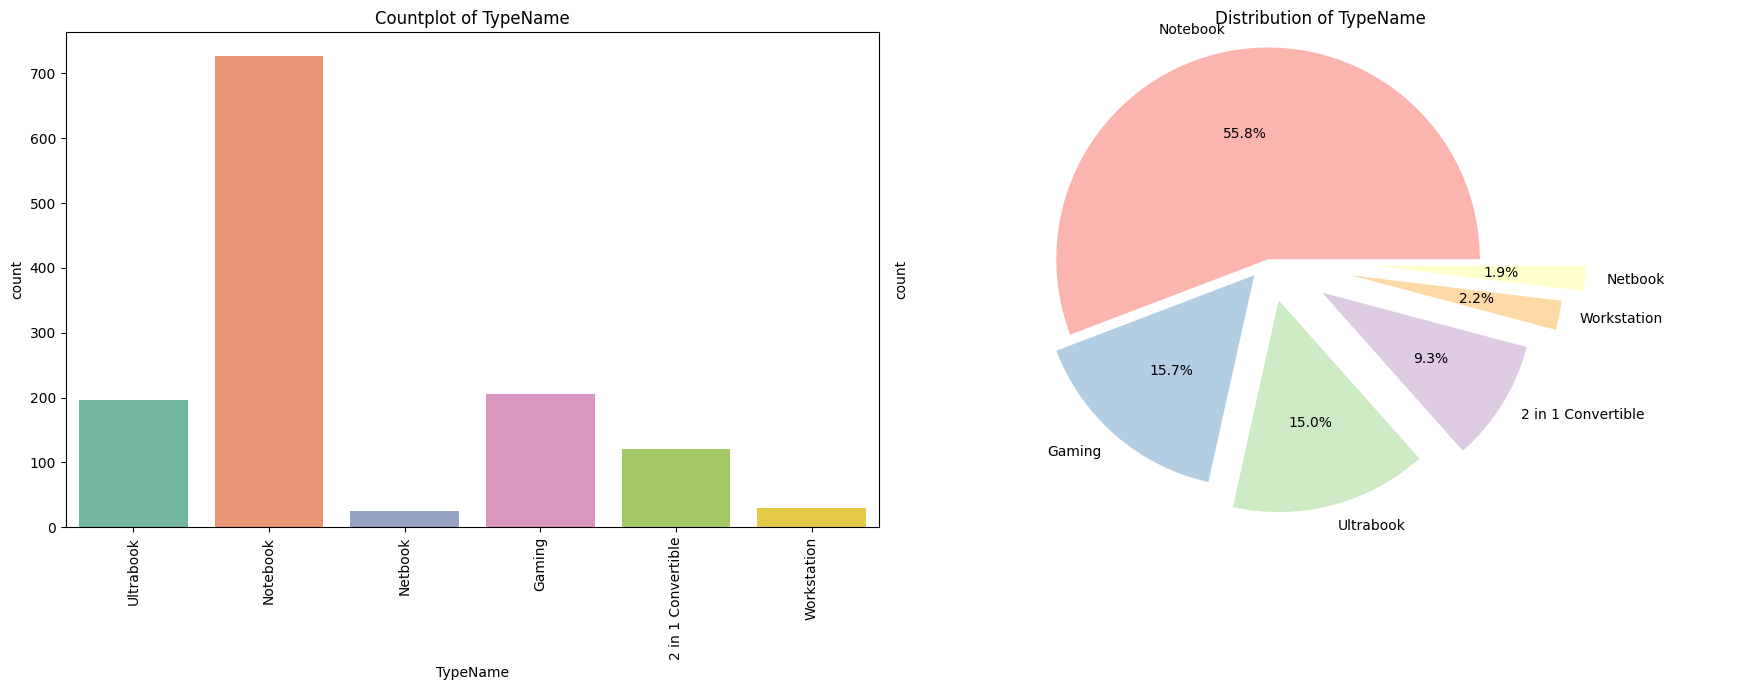

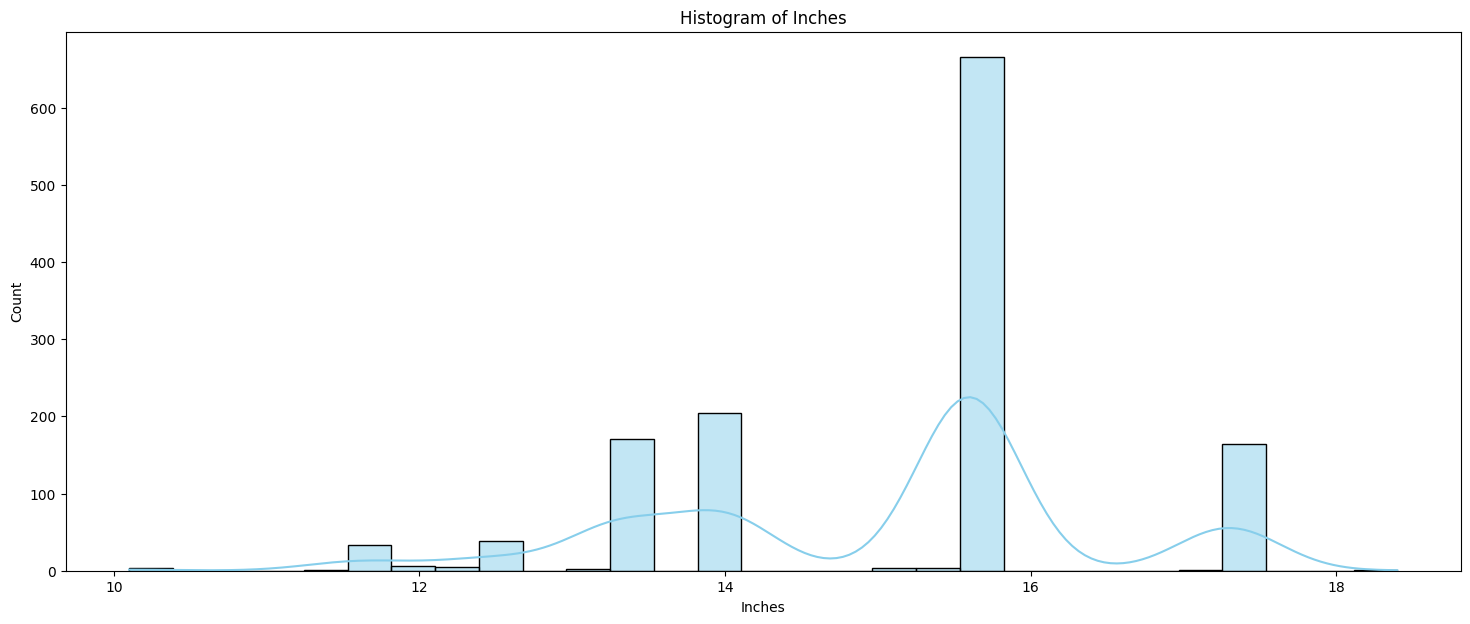

<Figure size 1800x700 with 0 Axes>

<Figure size 1800x700 with 0 Axes>

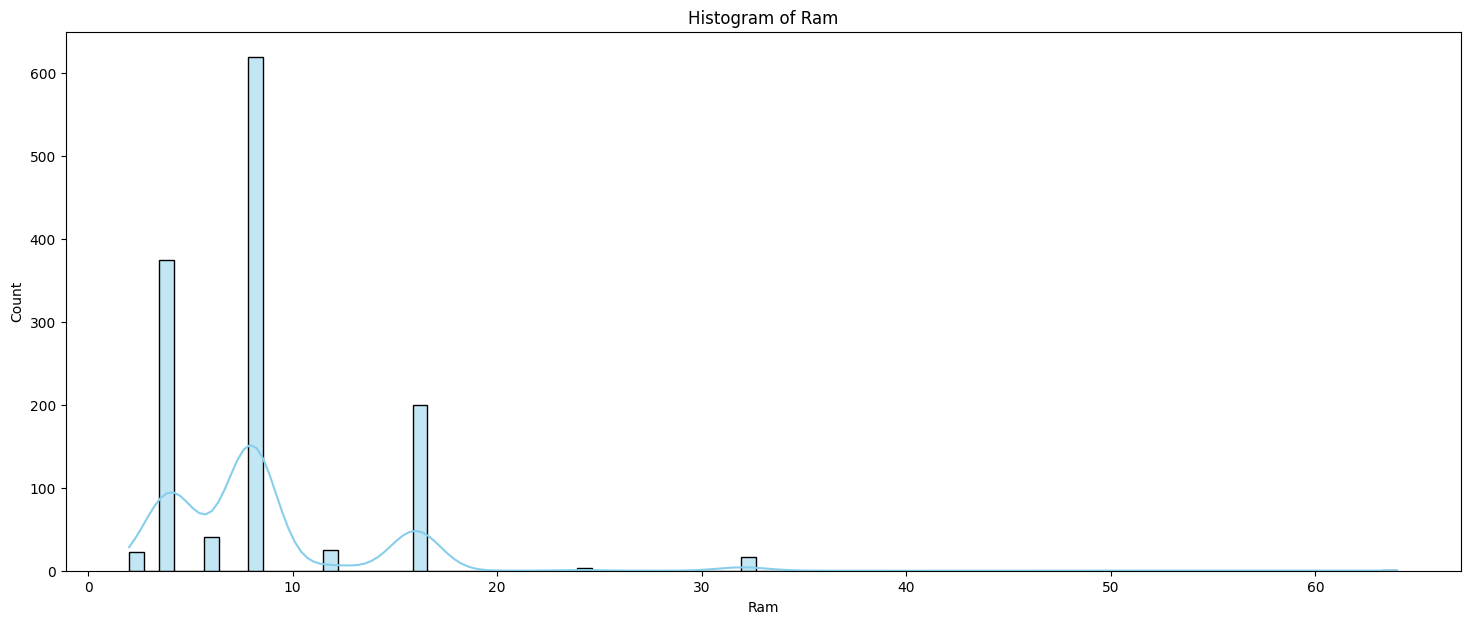

C:\Users\faisa\AppData\Local\Temp\ipykernel_5136\946364457.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Figure size 1800x700 with 0 Axes>

<Figure size 1800x700 with 0 Axes>

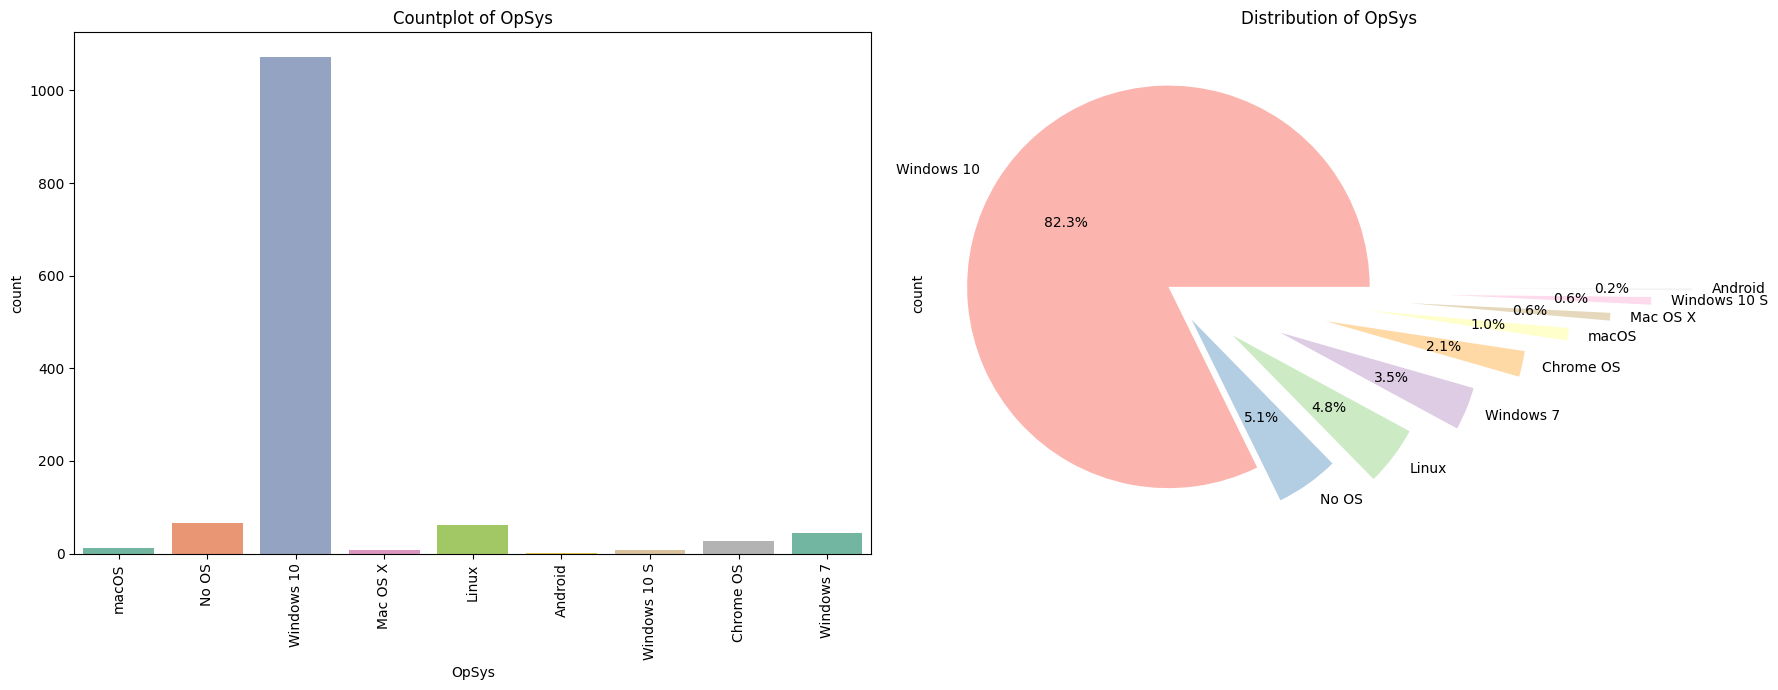

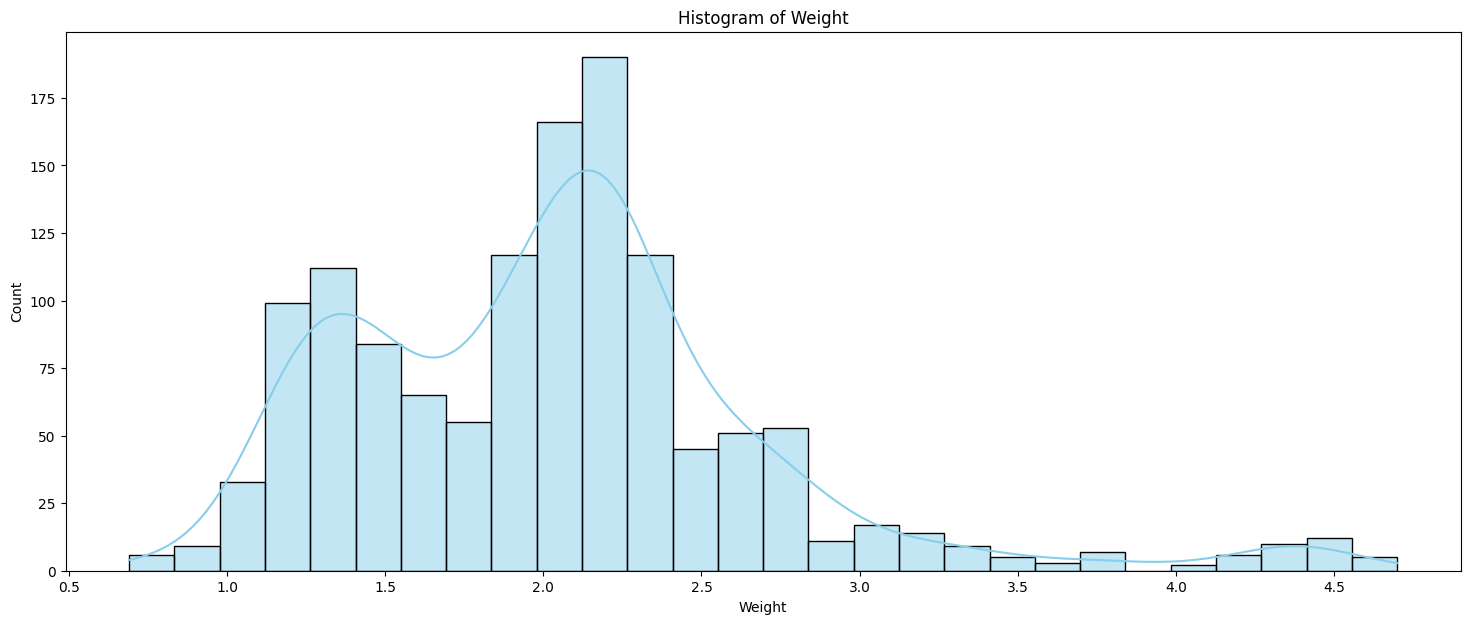

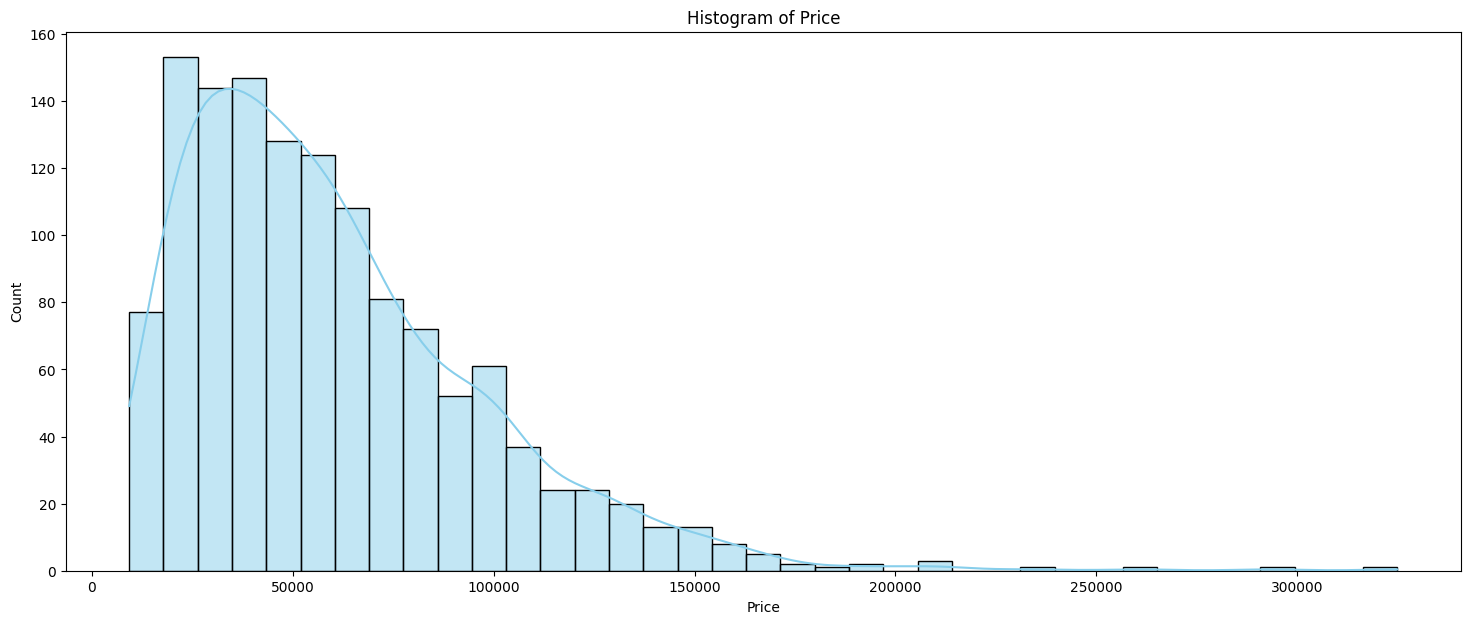

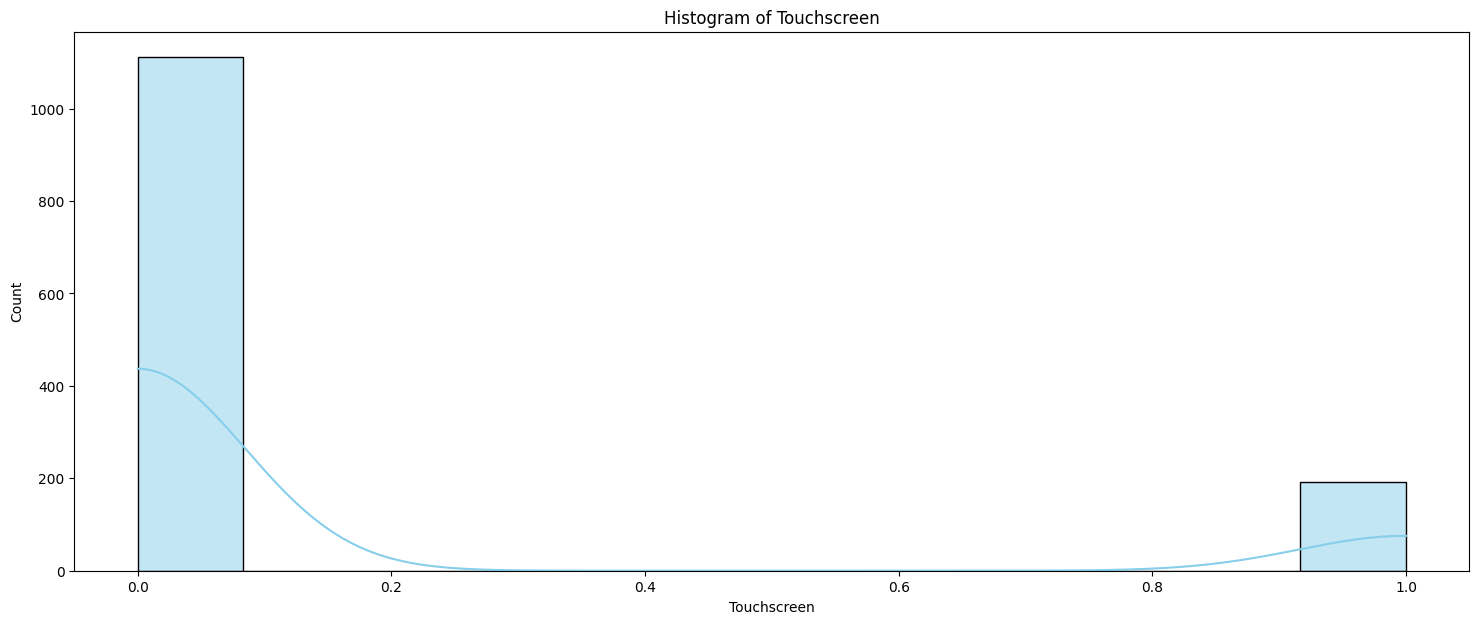

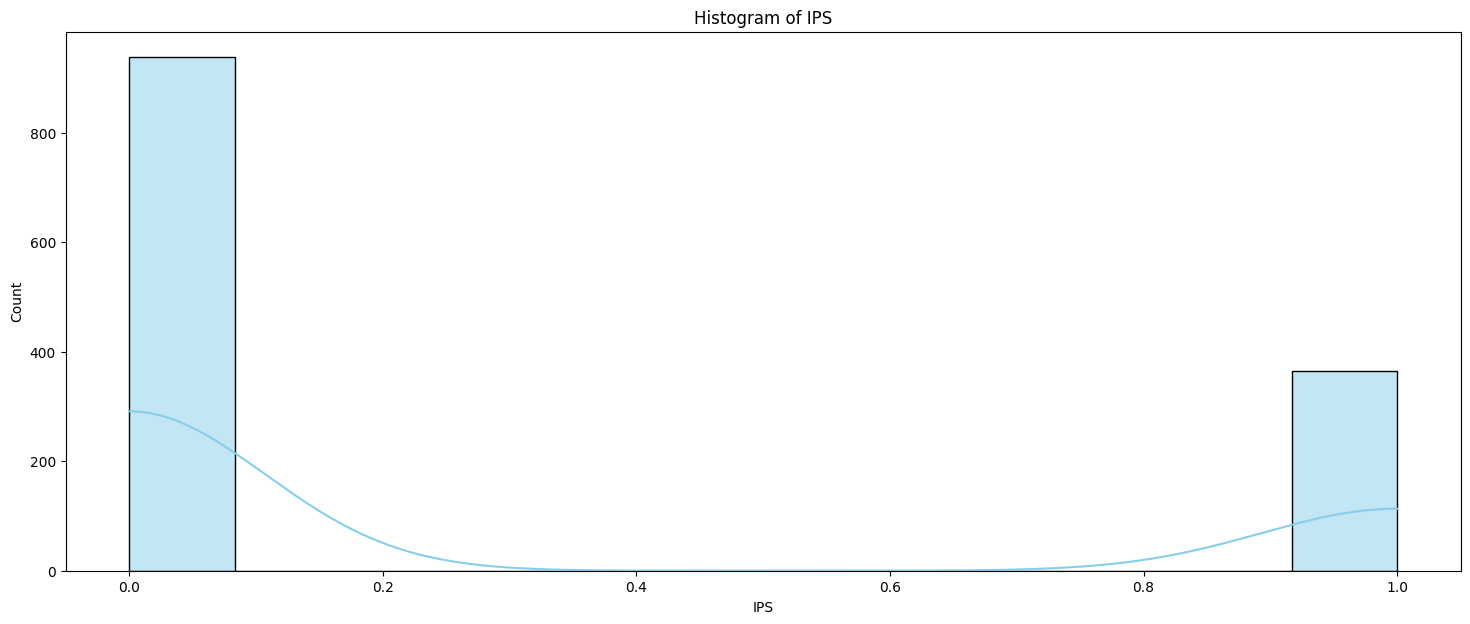

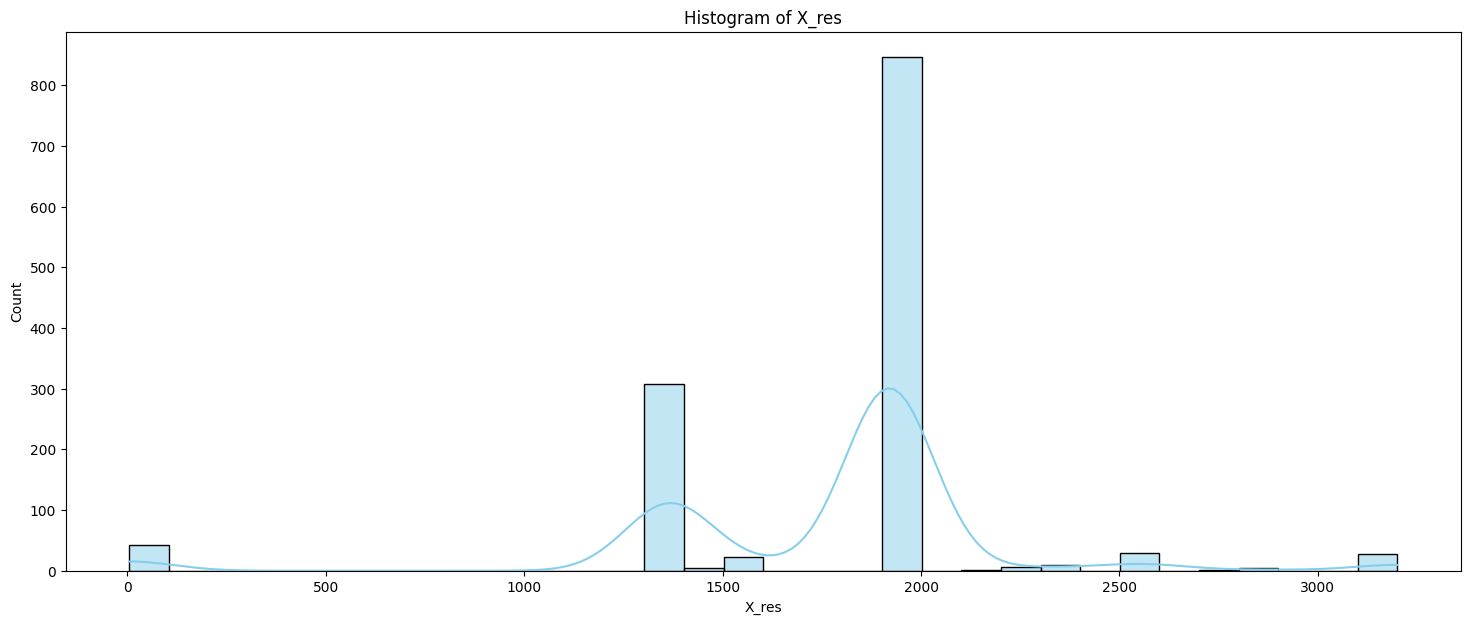

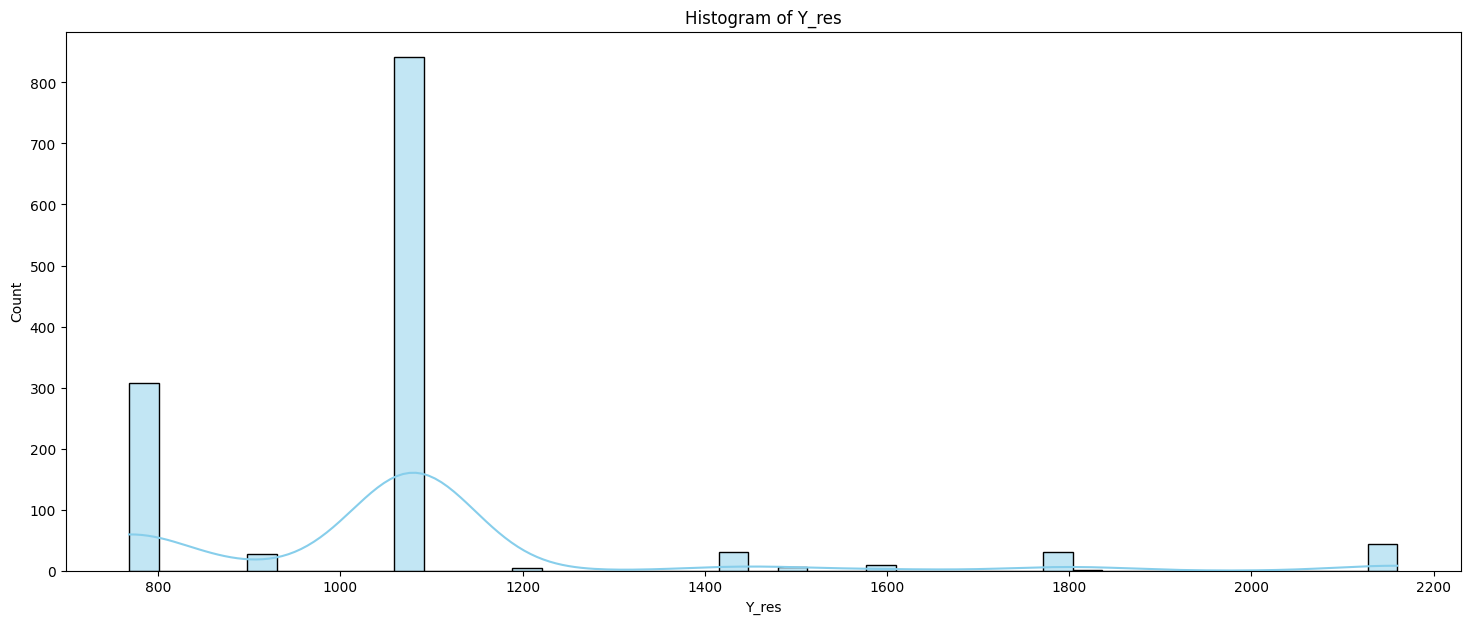

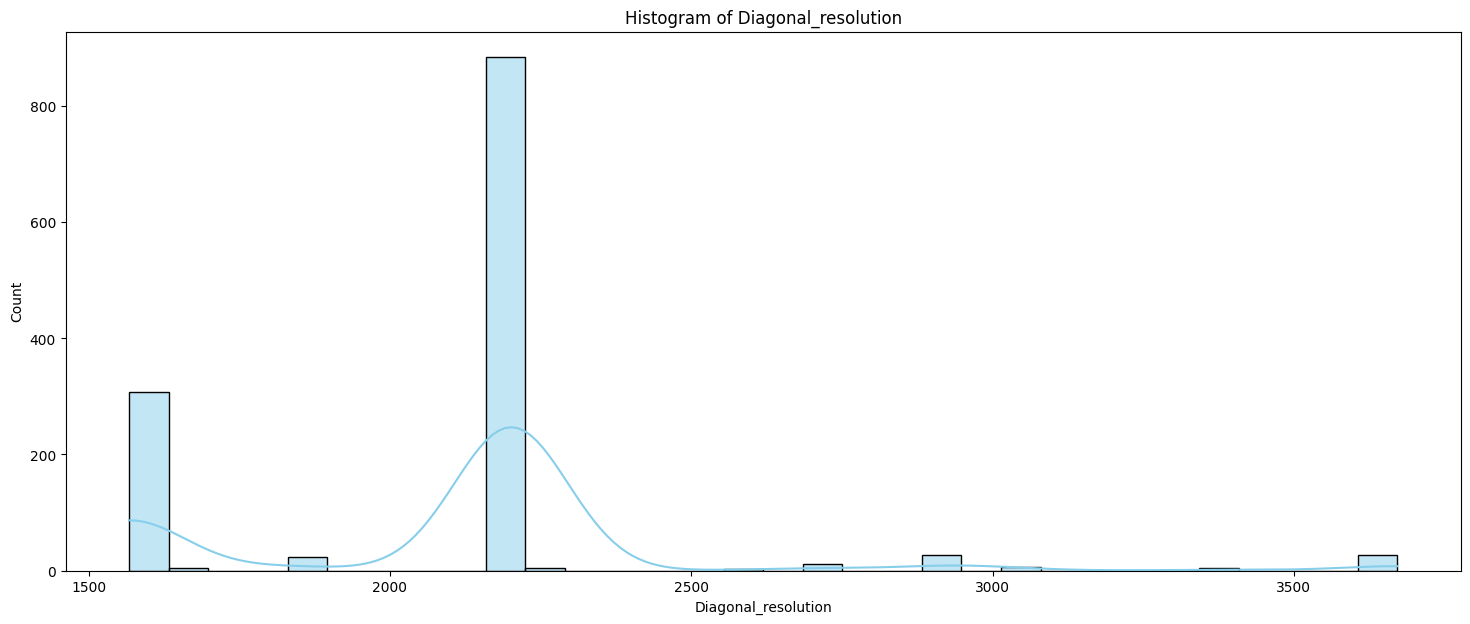

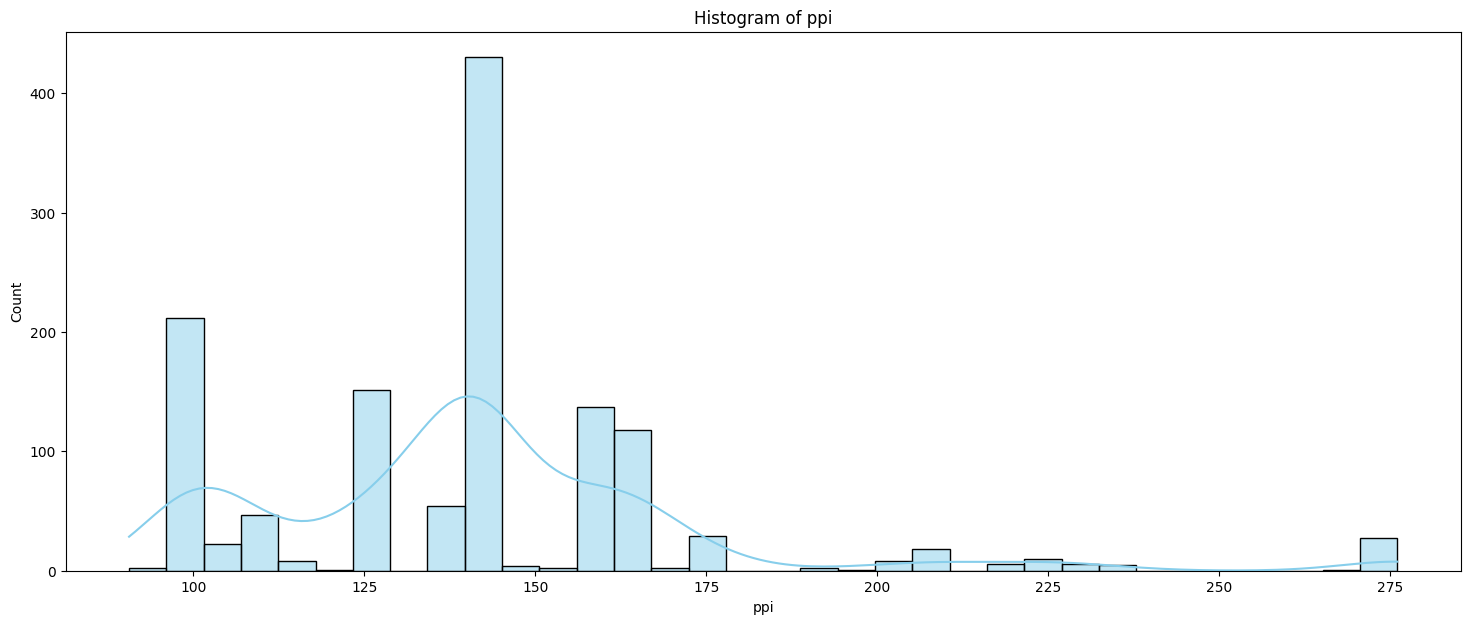

In [529]:
import matplotlib.pyplot as plt
import seaborn as sns

def univariate_analysis(df):
    """
    Perform univariate analysis on all columns of the dataframe.

    Parameters:
    - df: DataFrame
    """
    univariate_count = 0
    explode_factor = 0.1
    for column in df.columns:
        if univariate_count >= 30:  # Adjust the count as needed
            break
        plt.figure(figsize=(18, 7))
        if df[column].dtype == 'object':
            unique_values = df[column].nunique()
            if unique_values <= 10:
                # Countplot
                plt.subplot(1, 2, 1)
                sns.countplot(data=df, x=column, palette='Set2')
                plt.xticks(rotation=90)
                plt.title(f'Countplot of {column}')

                # Pie chart
                plt.subplot(1, 2, 2)
                counts = df[column].value_counts()
                explode = [explode_factor * i for i in range(len(counts))]
                counts.plot(kind='pie', autopct='%1.1f%%', explode=explode, colors=sns.color_palette('Pastel1', len(counts)))
                plt.title(f'Distribution of {column}')
                plt.axis('equal')

                plt.tight_layout()
                plt.show()
                univariate_count += 2
                explode_factor += 0.1
            elif unique_values <= 7:
                # Pie chart
                counts = df[column].value_counts()
                explode = [explode_factor * i for i in range(len(counts))]
                counts.plot(kind='pie', autopct='%1.1f%%', explode=explode, colors=sns.color_palette('Pastel1', len(counts)))
                plt.title(f'Distribution of {column}')
                plt.axis('equal')
                plt.show()
                univariate_count += 1
                explode_factor += 0.1
        else:
            # Histogram
            sns.histplot(data=df, x=column, kde=True, color='skyblue')
            plt.title(f'Histogram of {column}')
            plt.show()
            univariate_count += 1

# Call the function with the DataFrame
univariate_analysis(df)

In [530]:
import matplotlib.pyplot as plt
import seaborn as sns

def bivariate_analysis(df, x_column, y_column):
    """
    Perform bivariate analysis between two columns of the dataframe using different charts from Seaborn.

    Parameters:
    - df: DataFrame
    - x_column: str, name of the first column
    - y_column: str, name of the second column
    """
    plt.figure(figsize=(20, 7))

    # Box plot
    plt.subplot(1, 3, 1)
    if df[x_column].dtype == 'object':
        sns.boxplot(data=df, x=x_column, y=y_column)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Boxplot between {x_column} and {y_column}')

    # Bar plot
    plt.subplot(1, 3, 2)
    if df[x_column].dtype == 'object':
        sns.barplot(data=df, x=x_column, y=y_column)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Barplot between {x_column} and {y_column}')

    # Point plot
    plt.subplot(1, 3, 3)
    if df[x_column].dtype == 'object':
        sns.pointplot(data=df, x=x_column, y=y_column)
        plt.xticks(rotation=90)
        plt.title(f'Bivariate Pointplot between {x_column} and {y_column}')

    plt.tight_layout()
    plt.show()


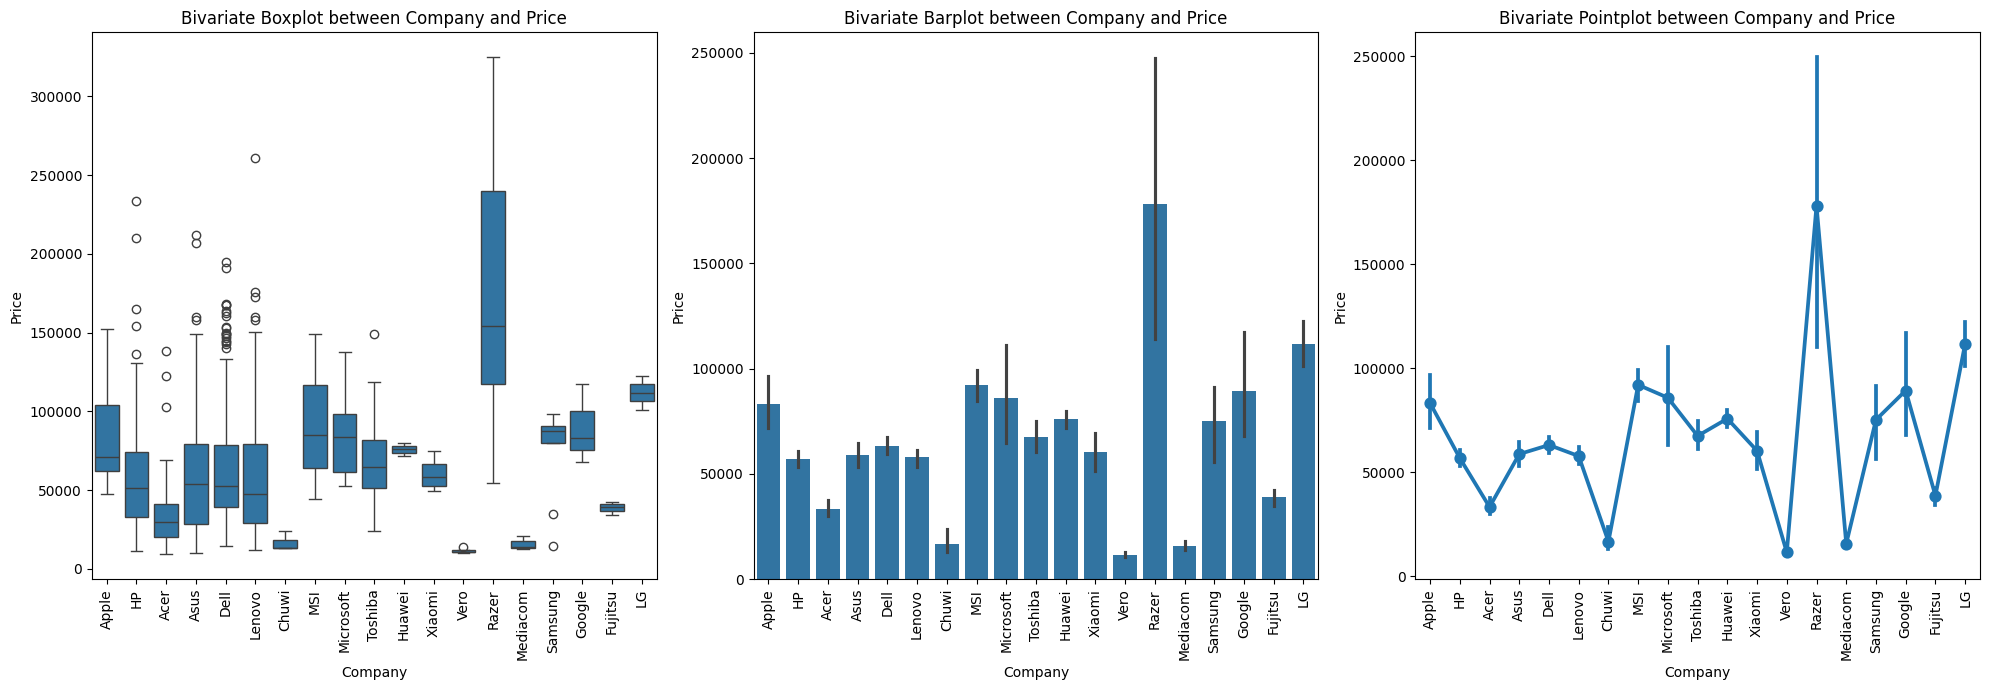

In [531]:
bivariate_analysis(df, 'Company', 'Price')




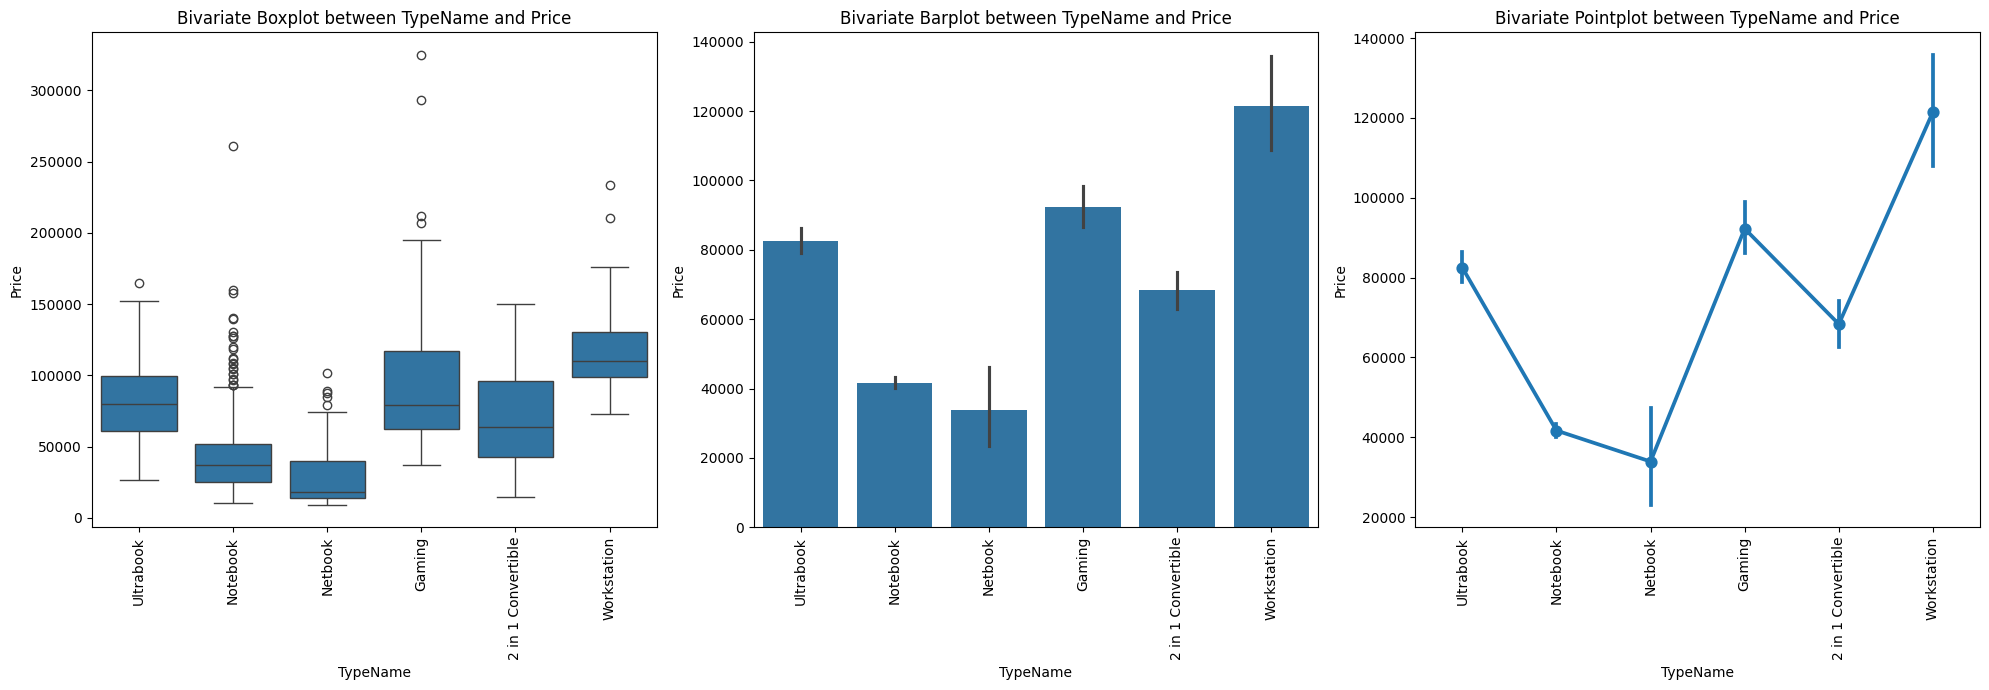

In [532]:
bivariate_analysis(df, 'TypeName', 'Price')

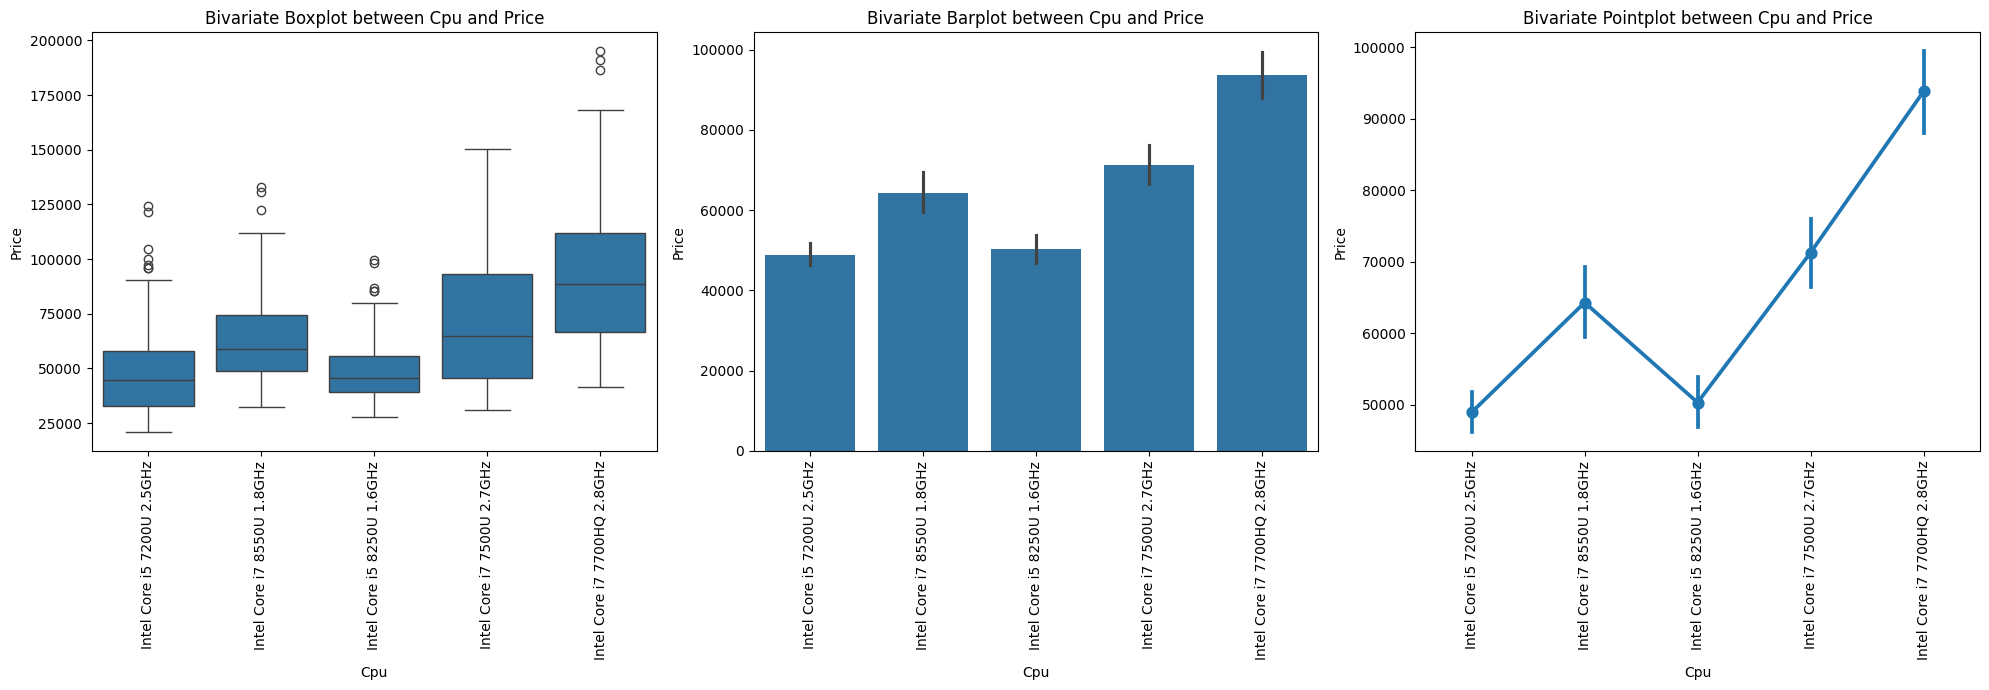

In [533]:
top_5_cpu = df['Cpu'].value_counts().index[:5]
bivariate_analysis(df[df['Cpu'].isin(top_5_cpu)], 'Cpu', 'Price')


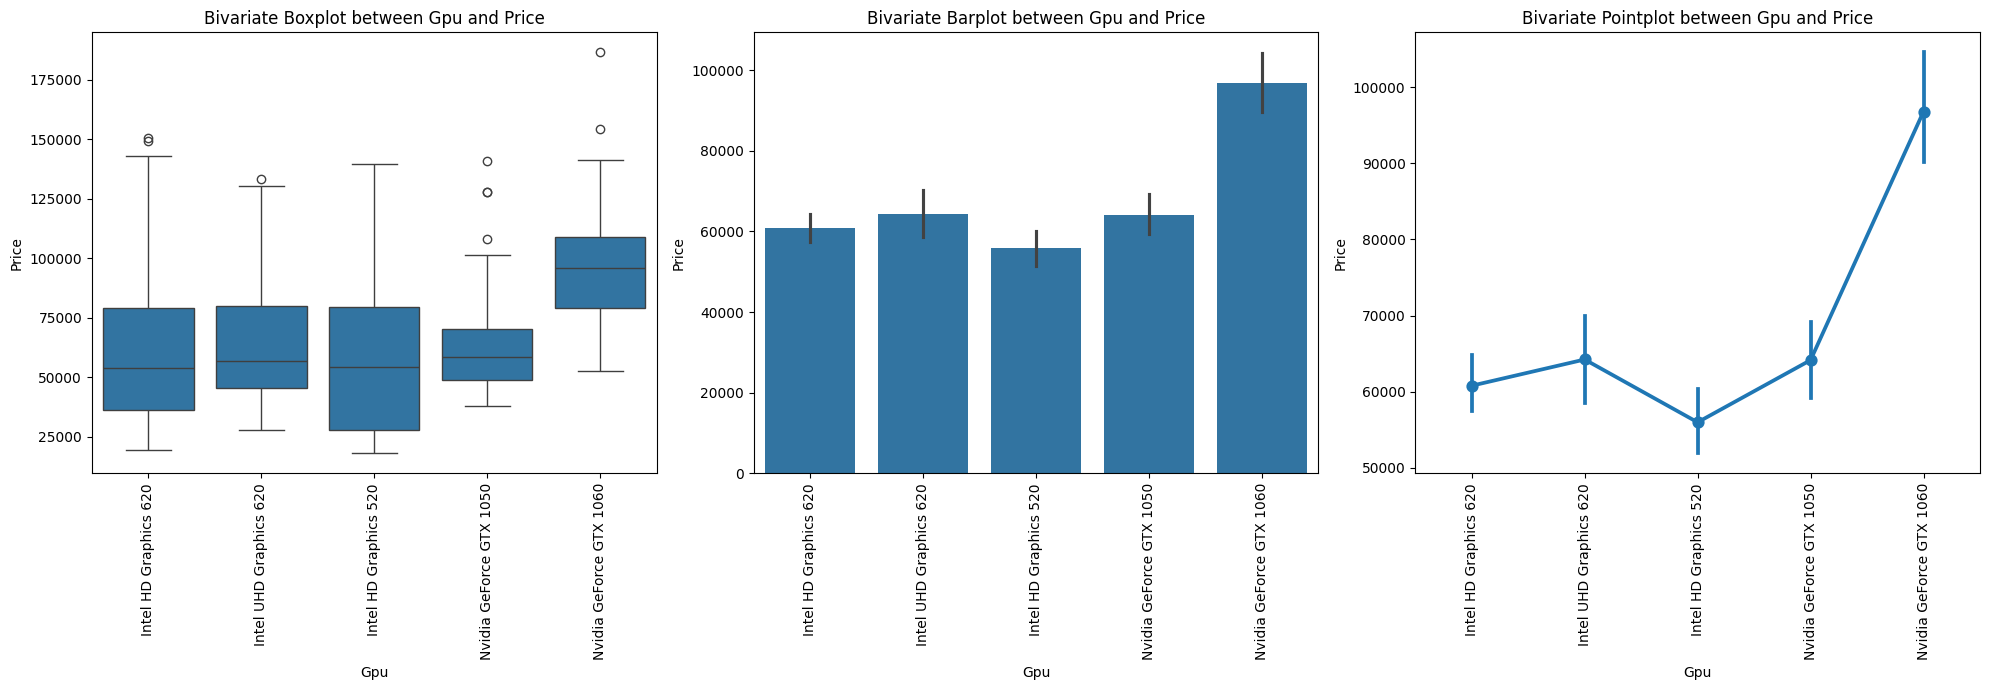

In [534]:
top_5_gpu = df['Gpu'].value_counts().index[:5]

bivariate_analysis(df[df['Gpu'].isin(top_5_gpu)], 'Gpu', 'Price')

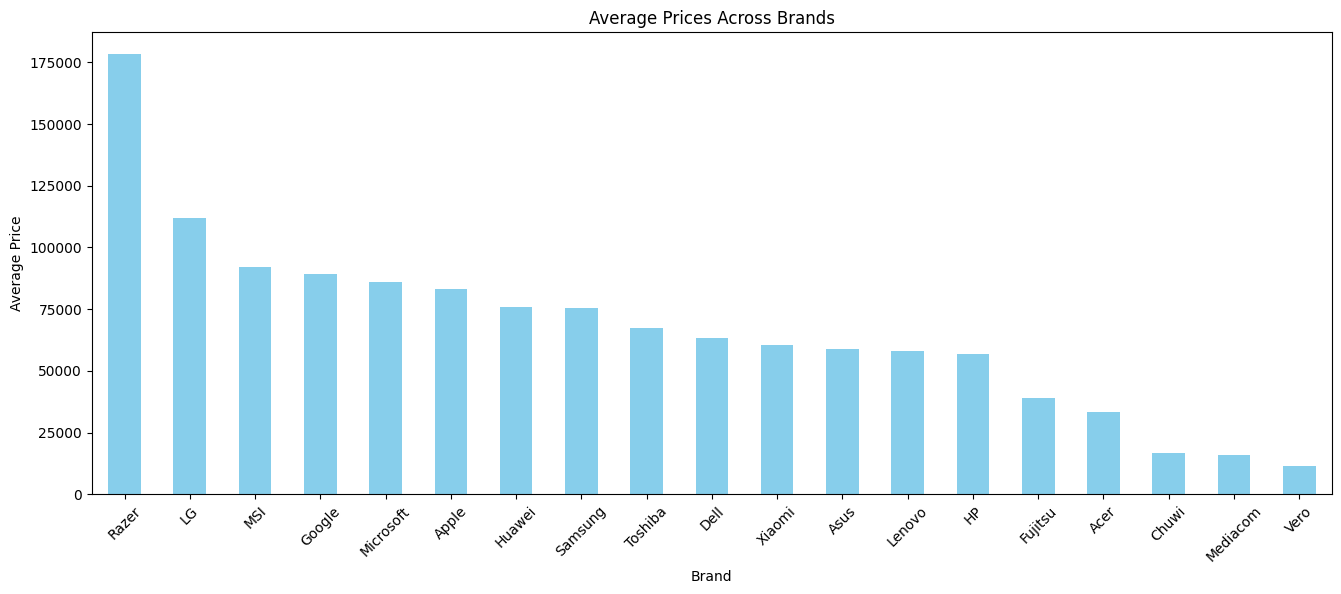

In [535]:
import matplotlib.pyplot as plt

def average_brand_prices(df):
    """
    Compute and visualize the average prices for each brand.

    Parameters:
    - df: DataFrame
    """
    brand_prices = df.groupby('Company')['Price'].mean().sort_values(ascending=False)
    plt.figure(figsize=(16, 6))
    brand_prices.plot(kind='bar', color='skyblue')
    plt.xticks(rotation=45)
    plt.xlabel('Brand')
    plt.ylabel('Average Price')
    plt.title('Average Prices Across Brands')
    plt.show()
average_brand_prices(df)

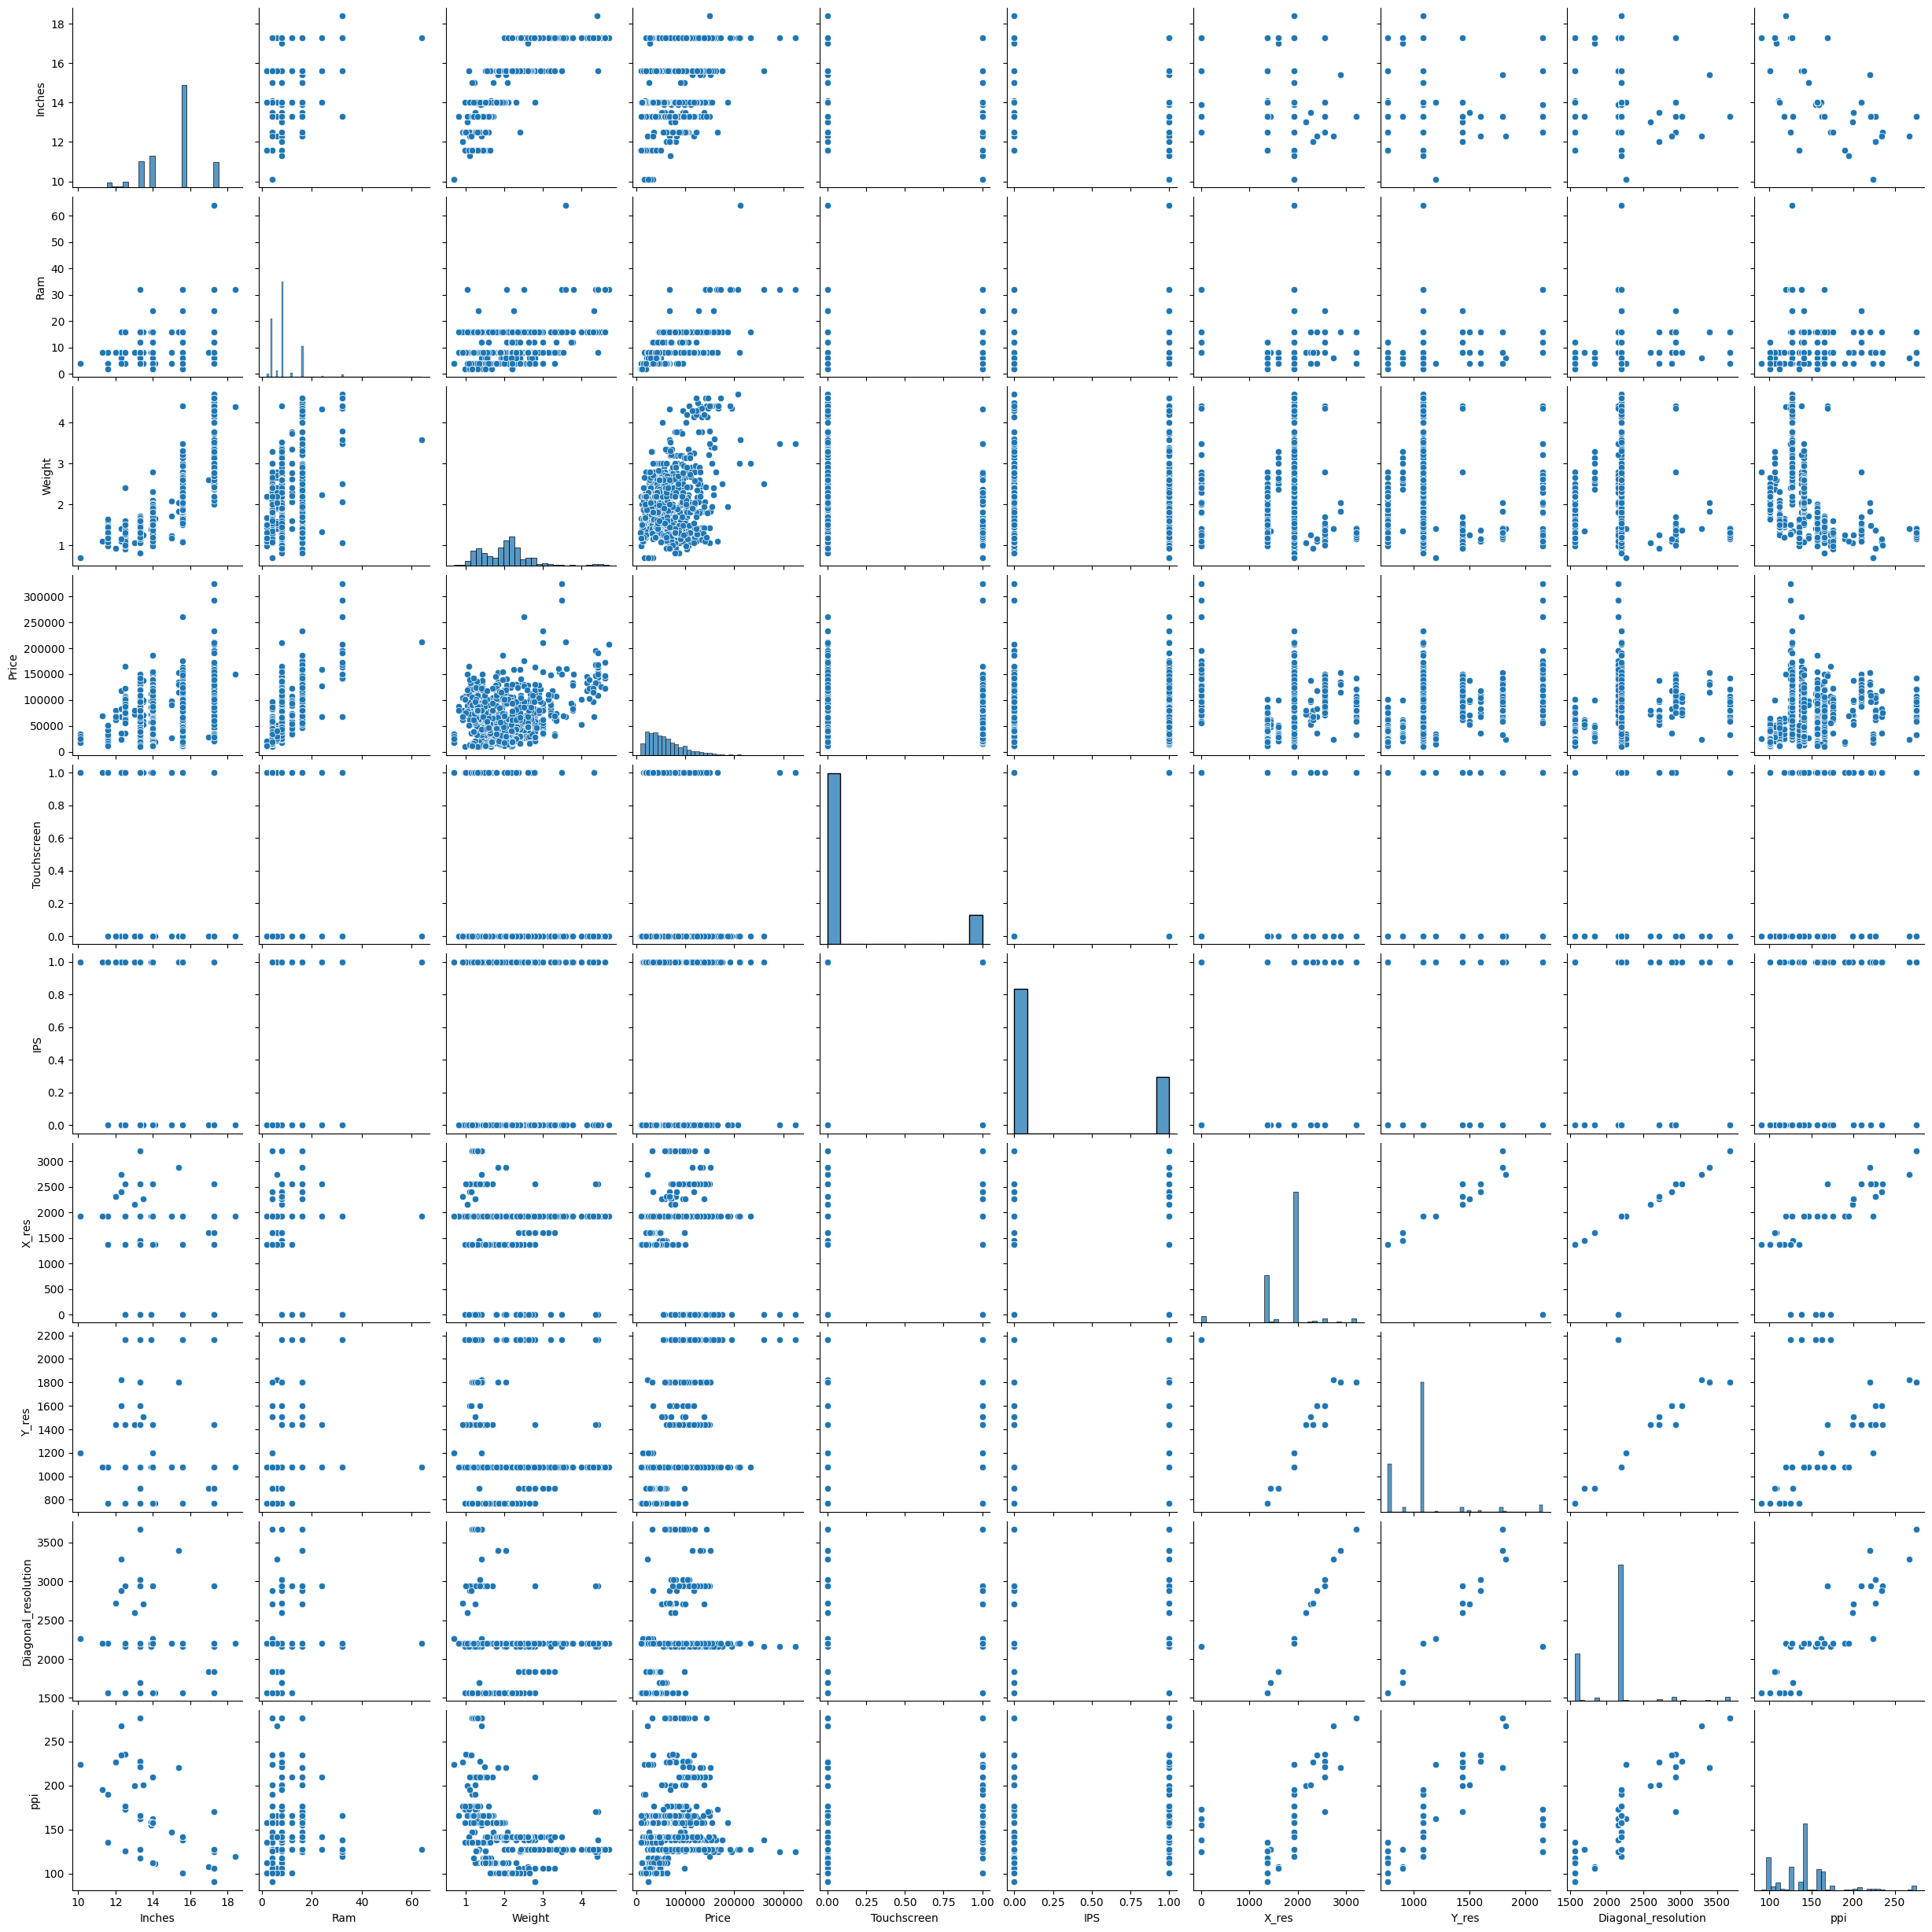

In [536]:
sns.pairplot(df)

In [537]:
import seaborn as sns

def correlation_plot_numeric(df):
    """
    Create a correlation plot for numeric columns in the DataFrame.

    Parameters:
    - df: DataFrame
    """
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Plot for Numeric Columns')
    plt.show()

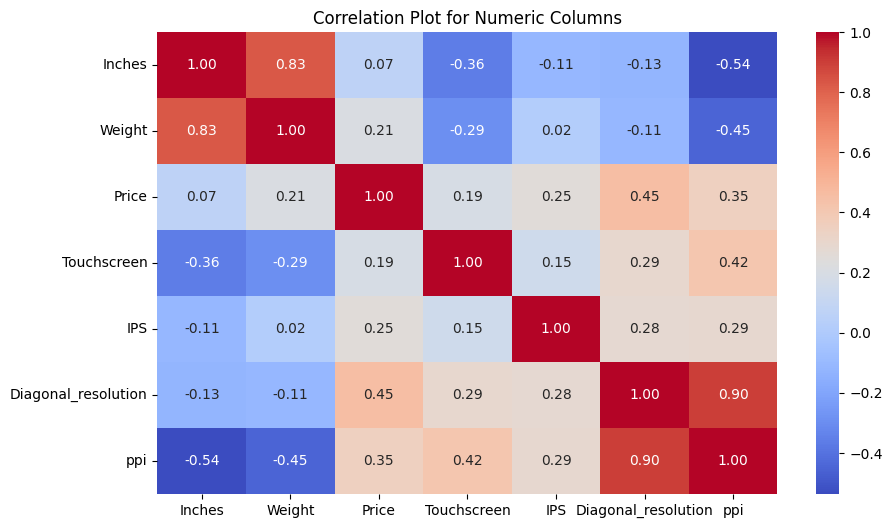

In [538]:
correlation_plot_numeric(df)

In [539]:
# Drop unnecessary columns
df.drop(columns=['Diagonal_resolution','ScreenResolution','Inches','X_res','Y_res'], inplace=True)